# Do delays depend more on the destination or the departure?

### Step 1: Load the Datasets

In [85]:
import pandas as pd
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt

original_data = pd.read_csv('../flights.csv', low_memory=False)
airlines_data = pd.read_csv('../airlines.csv', low_memory=False)
airports_data = pd.read_csv('../airports.csv', low_memory=False)

In [117]:
flights_data = original_data.copy()

In [120]:
#print(airports_data['IATA_CODE'].unique())
# Exclude rows where 'ORIGIN_AIRPORT' is a numeric code
#flights_data = flights_data[~flights_data['ORIGIN_AIRPORT'].str.isnumeric()]
print(flights_data['ORIGIN_AIRPORT'].unique())


['ANC' 'LAX' 'SFO' 'SEA' 'LAS' 'DEN' 'SLC' 'PDX' 'FAI' 'MSP' 'PHX' 'SJU'
 'PBG' 'IAG' 'PSE' 'BQN' 'ORD' 'GEG' 'HNL' 'ONT' 'MCO' 'BOS' 'HIB' 'ABR'
 'MAF' 'DFW' 'MKE' 'IAH' 'BNA' 'BRO' 'VPS' 'BOI' 'BJI' 'SGF' 'PHL' 'SBN'
 'RDD' 'EUG' 'IAD' 'BUF' 'PWM' 'JFK' 'CRP' 'PIA' 'FAT' 'SMF' 'AUS' 'MCI'
 'ATL' 'JAX' 'MFR' 'IDA' 'MSN' 'DCA' 'SAT' 'CHS' 'SBA' 'SMX' 'IND' 'CLE'
 'GSP' 'BDL' 'ABI' 'RIC' 'BFL' 'OMA' 'RDM' 'FLL' 'CID' 'TPA' 'SYR' 'ROC'
 'TYR' 'LAN' 'XNA' 'GSO' 'EWR' 'PBI' 'RSW' 'OAK' 'PVD' 'RNO' 'PIT' 'ABQ'
 'MIA' 'BWI' 'LGA' 'TUL' 'LIT' 'MSY' 'OKC' 'ATW' 'PNS' 'MEM' 'TYS' 'MHT'
 'SAV' 'CLT' 'GRB' 'ABE' 'JAN' 'OAJ' 'FAR' 'ERI' 'LEX' 'CWA' 'MSO' 'TTN'
 'AMA' 'CLL' 'HOU' 'JLN' 'MLI' 'RDU' 'CVG' 'MHK' 'MOB' 'TLH' 'BHM' 'CAE'
 'TXK' 'ACY' 'DTW' 'RAP' 'TUS' 'EAU' 'DLH' 'FSD' 'INL' 'CMX' 'SPI' 'CLD'
 'COD' 'CMH' 'LRD' 'PSC' 'CPR' 'ACV' 'DAL' 'PAH' 'MRY' 'ESC' 'ISN' 'PSP'
 'MFE' 'STL' 'BTV' 'FSM' 'AEX' 'SPS' 'ACT' 'SJT' 'MTJ' 'GCC' 'OGG' 'SJC'
 'GUC' 'ORF' 'MOT' 'MLU' 'KOA' 'SAN' 'LAW' 'PIB' 'M

### Step 2: Merge Datasets

In [87]:
# Renaming columns in airports_data
airports_data_origin = airports_data.rename(columns=lambda x: x + "_ORIGIN")
airports_data_destination = airports_data.rename(
    columns=lambda x: x + "_DESTINATION")

# Merging with airlines
flights_data = pd.merge(flights_data, airlines_data,
                        left_on='AIRLINE', right_on='IATA_CODE', how='left')


# Merging with airports for departure
flights_data = pd.merge(flights_data, airports_data_origin,
                        left_on='ORIGIN_AIRPORT', right_on='IATA_CODE_ORIGIN', how='left')

# Merging with airports for destination
flights_data = pd.merge(flights_data, airports_data_destination,
                        left_on='DESTINATION_AIRPORT', right_on='IATA_CODE_DESTINATION', how='left')

(5819079, 47)


### Step 3: Data Preprocessing

In [100]:
# You can drop or impute missing values based on your requirement
# TODO: Check if any preprocessing is required for the data
flights_data.dropna(subset=['DEPARTURE_DELAY', 'ARRIVAL_DELAY', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT'], inplace=True)
print(flights_data['ORIGIN_AIRPORT'].unique())


['ANC' 'LAX' 'SFO' 'SEA' 'LAS' 'DEN' 'SLC' 'PDX' 'FAI' 'MSP' 'PHX' 'SJU'
 'PBG' 'IAG' 'PSE' 'BQN' 'ORD' 'GEG' 'HNL' 'ONT' 'MCO' 'BOS' 'HIB' 'ABR'
 'DFW' 'MKE' 'IAH' 'BNA' 'BRO' 'VPS' 'BOI' 'BJI' 'PHL' 'SBN' 'EUG' 'IAD'
 'BUF' 'PWM' 'JFK' 'CRP' 'PIA' 'FAT' 'SMF' 'AUS' 'MCI' 'ATL' 'JAX' 'MFR'
 'IDA' 'MSN' 'DCA' 'SAT' 'CHS' 'SBA' 'IND' 'CLE' 'GSP' 'BDL' 'RIC' 'BFL'
 'OMA' 'RDM' 'FLL' 'CID' 'TPA' 'SYR' 'ROC' 'TYR' 'LAN' 'GSO' 'EWR' 'PBI'
 'RSW' 'OAK' 'PVD' 'RNO' 'PIT' 'ABQ' 'MIA' 'BWI' 'TUL' 'LGA' 'LIT' 'MSY'
 'OKC' 'ATW' 'PNS' 'MEM' 'TYS' 'MHT' 'SAV' 'CLT' 'GRB' 'ABE' 'JAN' 'OAJ'
 'FAR' 'ERI' 'LEX' 'CWA' 'TTN' 'RDU' 'CVG' 'BHM' 'ACY' 'DTW' 'RAP' 'TUS'
 'EAU' 'DLH' 'FSD' 'INL' 'SPI' 'CLD' 'COD' 'CMH' 'PSC' 'CPR' 'ACV' 'DAL'
 'PAH' 'MRY' 'ESC' 'ISN' 'PSP' 'CAE' 'STL' 'BTV' 'MTJ' 'GCC' 'OGG' 'SJC'
 'GUC' 'ORF' 'MOT' 'MLU' 'KOA' 'HOU' 'MOB' 'SAN' 'LAW' 'PIB' 'MGM' 'SBP'
 'COS' 'LAR' 'DRO' 'BIS' 'ITO' 'BTR' 'HLN' 'BZN' 'MDW' 'MDT' 'SCE' 'LIH'
 'TWF' 'BPT' 'GPT' 'STC' 'HPN' 'MLB' 'PLN' 'CIU' 'C

### Step 4: Analyzing Departure Delays

In [89]:
departure_delays = flights_data.groupby('ORIGIN_AIRPORT')['DEPARTURE_DELAY'].mean().reset_index()

    ORIGIN_AIRPORT  DEPARTURE_DELAY
0            10135         9.372385
1            10136         2.880208
2            10140         5.886427
3            10141         1.514286
4            10146         8.883721
..             ...              ...
623            WRG         2.953775
624            WYS         1.375000
625            XNA        11.810889
626            YAK        -6.507692
627            YUM         1.232470

[628 rows x 2 columns]


### Step 5: Analyzing Arrival Delays

In [90]:
destination_delays = flights_data.groupby('DESTINATION_AIRPORT')['ARRIVAL_DELAY'].mean().reset_index()

    DESTINATION_AIRPORT  ARRIVAL_DELAY
0                 10135       1.182979
1                 10136       1.221649
2                 10140       1.631143
3                 10141      -1.887324
4                 10146       7.126437
..                  ...            ...
624                 WRG       5.375767
625                 WYS       4.193237
626                 XNA       8.772090
627                 YAK       0.371166
628                 YUM       3.259159

[629 rows x 2 columns]


### Step 6: Statistical Analysis

In [91]:
t_stat, p_value = ttest_ind(departure_delays['DEPARTURE_DELAY'], destination_delays['ARRIVAL_DELAY'])
print("T-statistic:", t_stat)
print("P-value:", p_value)

T-statistic: 10.061056746618805
P-value: 5.924696378899846e-23


In [99]:
# TODO: DELTE AFTER
print(departure_delays)

    ORIGIN_AIRPORT  DEPARTURE_DELAY
0            10135         9.372385
1            10136         2.880208
2            10140         5.886427
3            10141         1.514286
4            10146         8.883721
..             ...              ...
623            WRG         2.953775
624            WYS         1.375000
625            XNA        11.810889
626            YAK        -6.507692
627            YUM         1.232470

[628 rows x 2 columns]


### Step 7: Visualization

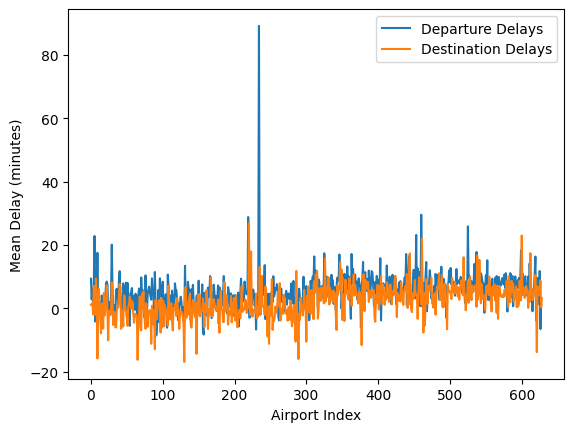

In [95]:
plt.plot(departure_delays['DEPARTURE_DELAY'], label='Departure Delays')
plt.plot(destination_delays['ARRIVAL_DELAY'], label='Destination Delays')
plt.xlabel('Airport Index')  # X-axis label
plt.ylabel('Mean Delay (minutes)')  # Y-axis label
plt.legend()
plt.show()

### Conclusion

Based on the p-value, you can conclude whether there's a significant difference between departure and destination delays. If the p-value is less than the chosen alpha level (e.g., 0.05), then you might conclude that there's a significant difference.

The code and steps provided will allow you to analyze and compare the delays based on departure and destination airports, thereby answering the question of whether delays depend more on the destination or the departure. Make sure to analyze the results in the context of your specific data and domain knowledge.